<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-26 13:02:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100% 16.7K=1.3s

2020-06-26 13:02:31 (16.7 KB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



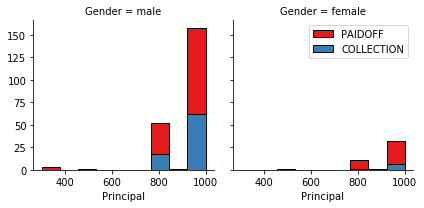

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

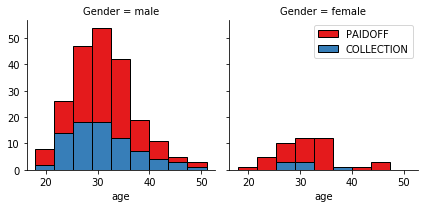

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

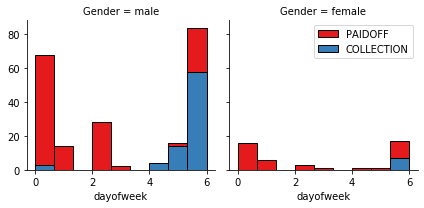

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

([array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([7., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([7., 0., 0., 0., 0., 0.

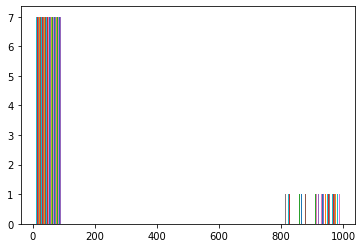

In [18]:
plt.hist(X)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

([array([  3.,   2.,   0.,   0.,  81.,   2., 258.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,  14., 148.,   0., 184.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,  26., 108., 124.,  57.,  24.,   7.]),
  array([  0.,   0.,   0.,   0.,   0., 294.,   0.,   0.,  52.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 141.,   0., 205.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 302.,   0.,   0.,   0.,  44.]),
  array([  0.,   0.,   0.,   0.,   0., 195.,   0., 151.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 197.,   0., 149.,   0.,   0.])],
 array([-5.89052444, -4.96882824, -4.04713204, -3.12543584, -2.20373963,
        -1.28204343, -0.36034723,  0.56134897,  1.48304517,  2.40474138,
         3.32643758]),
 <a list of 8 Lists of Patches objects>)

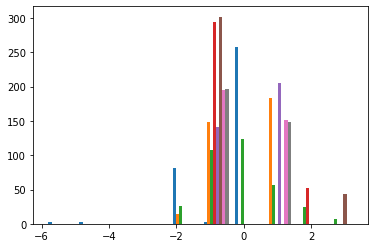

In [20]:
plt.hist(X)

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [21]:
# Evaluation Metrices
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

In [22]:
# Splitting Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [24]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score

ks = range(1, 10)
mean_accuracy = []

for n in ks:
    knn_model  = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    mean_accuracy.append(accuracy_score(y_test, knn_yhat))

In [25]:
for i in range(0, len(mean_accuracy)):
    print("k = {} has a Score = {} ".format(i+1, mean_accuracy[i]))

k = 1 has a Score = 0.6428571428571429 
k = 2 has a Score = 0.5571428571428572 
k = 3 has a Score = 0.7142857142857143 
k = 4 has a Score = 0.6285714285714286 
k = 5 has a Score = 0.7571428571428571 
k = 6 has a Score = 0.6571428571428571 
k = 7 has a Score = 0.7571428571428571 
k = 8 has a Score = 0.7142857142857143 
k = 9 has a Score = 0.7 


Text(0, 0.5, 'Testing Accuracy Values')

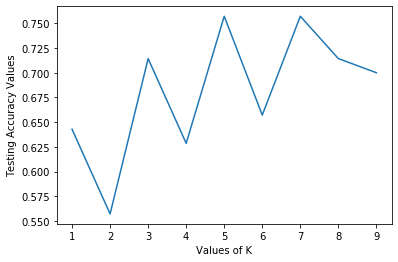

In [26]:
# Relation between k's and their respective accuracies

plt.plot(ks, mean_accuracy)
plt.xlabel('Values of K')
plt.ylabel('Testing Accuracy Values')

In [27]:
# Final Model with best value of k

knn_model = knn(n_neighbors = 7)
knn_model.fit(X_train, y_train)
knn_yhat = knn_model.predict(X_test)

knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

# Decision Tree

In [28]:
# Libraries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [29]:
depth_range = range(1, 10)
jaccard_similarity_score_ = []
f1_score_ = []

for d in depth_range:
    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = d)
    dt.fit(X_train, y_train)
    dt_yhat = dt.predict(X_test)
    jaccard_similarity_score_.append(jaccard_similarity_score(y_test, dt_yhat))
    f1_score_.append(f1_score(y_test, dt_yhat, average = 'weighted'))

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-package

In [30]:
# Creating a df to check the best value of max_depth

result = pd.DataFrame([jaccard_similarity_score_, f1_score_], index = ['Jaccard', 'F1'], columns = ['d = 1','d = 2','d = 3','d = 4','d = 5','d = 6','d = 7','d = 8','d = 9'])
result.columns.name = 'Evaluation Metrices'
result

Evaluation Metrices,d = 1,d = 2,d = 3,d = 4,d = 5,d = 6,d = 7,d = 8,d = 9
Jaccard,0.828571,0.828571,0.800000,0.70000,0.642857,0.671429,0.714286,0.714286,0.742857
F1,0.750893,0.750893,0.736508,0.69476,0.657958,0.676571,0.722768,0.722768,0.742857


In [31]:
# Main Model

dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 2)
dt_model.fit(X_train, y_train)
dt_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Support Vector Machine

In [32]:
# Libraries

from sklearn.svm import SVC 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
accuracy_score = []

for k in kernel_func:
    svc_model = SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(X_train, y_train)
    svc_yhat = svc_model.predict(X_test)
    accuracy_score.append(f1_score(y_test, svc_yhat, average = 'weighted'))

Text(0, 0.5, 'Accuracy')

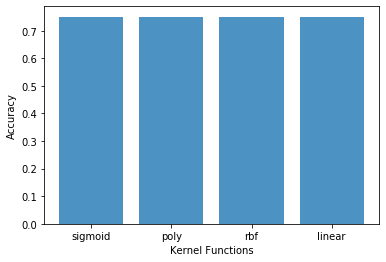

In [34]:
# Visualization of best kernel

y_pos = np.arange(len(kernel_func))
plt.bar(y_pos, accuracy_score, align='center', alpha = 0.8)
plt.xticks(y_pos, kernel_func)
plt.xlabel('Kernel Functions')
plt.ylabel('Accuracy')

In [35]:
svc_model = SVC(C = 0.01, gamma = 'auto', kernel = 'poly')
svc_model.fit(X_train, y_train)
svc_model

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression

In [36]:
# Libraries

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
regularization_val = [0.1, 0.01, 0.001]
index = []
accuracy_score = []
iterations = 0

for index1, c in enumerate(regularization_val):
    for index2, solver in enumerate(solvers):
        index.append(index1 + index2 *5)
        iterations +=1
        lr_model = LogisticRegression(C = c, solver = solver)
        lr_model.fit(X_train, y_train)
        lr_yhat = lr_model.predict(X_test)
        y_prob = lr_model.predict_proba(X_test)
        print('Test {}: Accuracy at C = {} when Solver = {} is : {}'.format(iterations, c, solver, log_loss(y_test, y_prob) ))
        accuracy_score.append(log_loss(y_test, y_prob))
                              
    print('\n')

Test 1: Accuracy at C = 0.1 when Solver = lbfgs is : 0.43437308682010156
Test 2: Accuracy at C = 0.1 when Solver = saga is : 0.4343733612098528
Test 3: Accuracy at C = 0.1 when Solver = liblinear is : 0.45495073415382825
Test 4: Accuracy at C = 0.1 when Solver = newton-cg is : 0.43437272447873787
Test 5: Accuracy at C = 0.1 when Solver = sag is : 0.43436978869503584


Test 6: Accuracy at C = 0.01 when Solver = lbfgs is : 0.4529024775789561
Test 7: Accuracy at C = 0.01 when Solver = saga is : 0.4529008818760716
Test 8: Accuracy at C = 0.01 when Solver = liblinear is : 0.5596633457155463
Test 9: Accuracy at C = 0.01 when Solver = newton-cg is : 0.4529024348154771
Test 10: Accuracy at C = 0.01 when Solver = sag is : 0.45291476094795247


Test 11: Accuracy at C = 0.001 when Solver = lbfgs is : 0.4787024545768455
Test 12: Accuracy at C = 0.001 when Solver = saga is : 0.4787026726844642
Test 13: Accuracy at C = 0.001 when Solver = liblinear is : 0.6685399066061889
Test 14: Accuracy at C = 0.

Text(0, 0.5, 'Testing Accuracy')

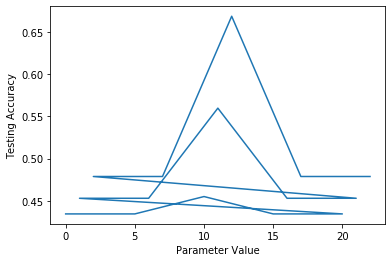

In [38]:
# Visualization

lr_prob = lr_model.predict_proba(X_test)
log_loss(y_test, lr_prob)
plt.plot(index, accuracy_score)
plt.xlabel('Parameter Value')
plt.ylabel('Testing Accuracy')

In [39]:
# Main Model

from sklearn.linear_model import LogisticRegression 

lr_model = LogisticRegression(C = 0.001, solver = 'liblinear')
lr_model.fit(X_train, y_train)
lr_model

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-26 13:02:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 8.27M=0s

2020-06-26 13:02:52 (8.27 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [43]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Testing feature
X_loan_test = test_feature

# Normalizing Test Data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)

# Target result
y_loan_test = test_df['loan_status'].values

In [44]:
print (X_loan_test[0:5])
print (X_loan_test.shape)

print (y_loan_test[0:5])
print (y_loan_test.shape)

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
(54, 8)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54,)


In [45]:
# Jaccard
from sklearn.metrics import jaccard_similarity_score

# KNN
knn_yhat = knn_model.predict(X_loan_test)
jss1 = round(jaccard_similarity_score(y_loan_test, knn_yhat), 2)

# Decision Tree
dt_yhat = dt_model.predict(X_loan_test)
jss2 = round(jaccard_similarity_score(y_loan_test, dt_yhat), 2)

# Support Vector Machine
svc_yhat = svc_model.predict(X_loan_test)
jss3 = round(jaccard_similarity_score(y_loan_test, svc_yhat), 2)

# Logistic Regression
lr_yhat = lr_model.predict(X_loan_test)
jss4 = round(jaccard_similarity_score(y_loan_test, lr_yhat), 2)

jss_list = [jss1, jss2, jss3, jss4]
jss_list

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\DELL\anaconda3\lib\site-package

[0.72, 0.74, 0.74, 0.78]

In [46]:
# F1_score
from sklearn.metrics import f1_score

# KNN
knn_yhat = knn_model.predict(X_loan_test)
f1 = round(f1_score(y_loan_test, knn_yhat, average = 'weighted'), 2)

# Decision Tree
dt_yhat = dt_model.predict(X_loan_test)
f2 = round(f1_score(y_loan_test, dt_yhat, average = 'weighted'), 2)

# Support Vector Machine
svc_yhat = svc_model.predict(X_loan_test)
f3 = round(f1_score(y_loan_test, svc_yhat, average = 'weighted'), 2)

# Logistic Regression
lr_yhat = lr_model.predict(X_loan_test)
f4 = round(f1_score(y_loan_test, lr_yhat, average = 'weighted'), 2)

f1_list = [f1, f2, f3, f4]
f1_list

[0.71, 0.63, 0.63, 0.76]

In [47]:
# log loss
from sklearn.metrics import log_loss

# Logistic Regression
lr_prob = lr_model.predict_proba(X_loan_test)
ll_list = ['NA','NA','NA', round(log_loss(y_loan_test, lr_prob), 2)]
ll_list

['NA', 'NA', 'NA', 0.67]

In [48]:
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

In [52]:
accuracy_df = pd.DataFrame([jss_list, f1_list, ll_list], index = index, columns = columns)

In [55]:
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Algorithm,Jaccard,F1-score,Logloss
KNN,0.72,0.71,NA
Decision Tree,0.74,0.63,NA
SVM,0.74,0.63,NA
Logistic Regression,0.78,0.76,0.67


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>